In [1]:
import os
import numpy as np
import cv2
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Định nghĩa đường dẫn dataset
train_dir = "C:/Users/VuongPham/Documents/asl_alphabet/asl_alphabet_train"
processed_data_dir = "C:/Users/VuongPham/Documents/asl_alphabet/processed_data"
test_dir = "C:/Users/VuongPham/Documents/asl_alphabet/test_data"

# Nhãn ký hiệu
labels = ["K", "L", "M", "N", "O"]
img_size = (192,192)
batch_size = 64

In [3]:
# Khởi tạo MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Tiền xử lý dữ liệu
def extract_hand(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            points = [(int(lm.x * image.shape[1]), int(lm.y * image.shape[0])) for lm in hand_landmarks.landmark]

            x_min, y_min = max(min(p[0] for p in points) - 20, 0), max(min(p[1] for p in points) - 20, 0)
            x_max, y_max = min(max(p[0] for p in points) + 20, image.shape[1]), min(max(p[1] for p in points) + 20, image.shape[0])

            hand_crop = image[y_min:y_max, x_min:x_max]
            if hand_crop.shape[0] > 0 and hand_crop.shape[1] > 0:
                return hand_crop
    return None

In [ ]:
# Xử lý và lưu dataset
for label in labels:
    label_dir = os.path.join(processed_data_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    folder_path = os.path.join(train_dir, label)
    count = 0

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue  # Bỏ qua ảnh lỗi

        hand_crop = extract_hand(image)
        if hand_crop is not None:
            image_resized = cv2.resize(hand_crop, img_size, interpolation=cv2.INTER_AREA)
            save_path = os.path.join(label_dir, img_name)
            cv2.imwrite(save_path, image_resized)
            count += 1

    print(f"Label [{label}]: {count} images processed.")

In [3]:
# Tạo Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18336 images belonging to 5 classes.
Found 4582 images belonging to 5 classes.
Found 2544 images belonging to 5 classes.


In [4]:
# Xây dựng mô hình CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(192,192, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'), 
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị kiến trúc mô hình
model.summary()

C:\Users\VuongPham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,397,829 (74.00 MB)

 Trainable params: 19,396,869 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_reduction]
)

model.save("customcnn_model.h5")

C:\Users\VuongPham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1045s 4s/step - accuracy: 0.4368 - loss: 3.6983 - val_accuracy: 0.5923 - val_loss: 2.7213 - learning_rate: 0.0100
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1116s 4s/step - accuracy: 0.7228 - loss: 2.1036 - val_accuracy: 0.7265 - val_loss: 1.9623 - learning_rate: 0.0100
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1418s 5s/step - accuracy: 0.8264 - loss: 1.7246 - val_accuracy: 0.7244 - val_loss: 1.8280 - learning_rate: 0.0100
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1423s 5s/step - accuracy: 0.8635 - loss: 1.5168 - val_accuracy: 0.7457 - val_loss: 1.6628 - learning_rate: 0.0100
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1419s 5s/step - accuracy: 0.9086 - loss: 1.3069 - val_accuracy: 0.8051 - val_loss: 1.5188 - learning_rate: 0.0100
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1412s 5s/step - accuracy: 0.9275 - loss: 1.1655 - val_accuracy: 0.8309 - val_loss: 1.3788 - learning_rate: 0.0100
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1410s 5s/step - accuracy: 0.9358 - l

Validation Accuracy: 87.23%
Test Accuracy: 97.52%


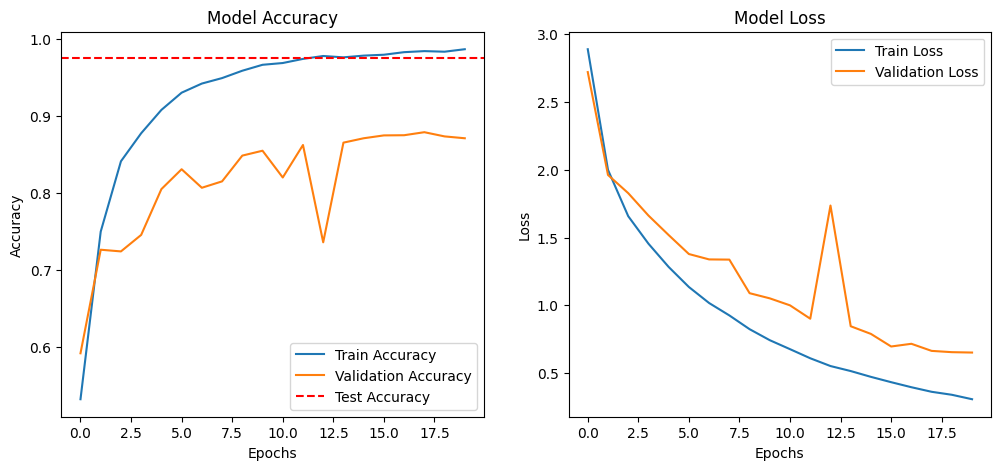

In [8]:
# Đánh giá mô hình trên tập validation
val_score = model.evaluate(val_generator, verbose=0)
print(f'Validation Accuracy: {val_score[1] * 100:.2f}%')

# Đánh giá mô hình trên tập test
test_score = model.evaluate(test_generator, verbose=0)
print(f'Test Accuracy: {test_score[1] * 100:.2f}%')

# Vẽ biểu đồ độ chính xác và loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_score[1], color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
# Chạy Webcam dự đoán
model = load_model("customcnn_model.h5")
# model = load_model("resnet50_model.h5")

def detect_and_predict(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hand_crop = extract_hand(frame_rgb)

    if hand_crop is not None and hand_crop.size != 0:
        hand_crop = cv2.resize(hand_crop, (192,192))
        input_image = hand_crop.reshape(1, 192,192, 3) / 255.0
        prediction = model.predict(input_image)
        return labels[np.argmax(prediction)]
    return None

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    label = detect_and_predict(frame)
    if label:
        cv2.putText(frame, f'Prediction: {label}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('ASL Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/ste